In [7]:
import itertools
import random
import sys
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg
from numpy.lib.scimath import sqrt as csqrt
import pennylane as qml
from pennylane import numpy as pnp
from scipy import stats
from scipy.sparse import random
from scipy.sparse.linalg import eigs
from scipy.stats import unitary_group
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (mean_absolute_error, median_absolute_error,
                             r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from QRC_pl import QuantumRC  # <-- Pennylane-Version verwenden

In [8]:
def market_direction_accuracy(y_train_pred, y_train, y_val_pred, y_val, y_test_pred, y_test,
                             date_train, date_val, date_test, int_acc = 0.05):
    #train = pd.DataFrame([y_train_pred, y_train, date_train], index = ['priceFH_predicted', 'priceFH', 'date']).T
    #train = train.set_index('date').sort_index()
    train = pd.DataFrame({
    "priceFH_predicted": y_train_pred,
    "priceFH": y_train,
    "date": pd.to_datetime(date_train)}).set_index("date").sort_index()

    train['pred_diff'] = train['priceFH_predicted']-train['priceFH'].shift(1)

    train['priceFH_diff'] = train['priceFH'].diff()
    train['trend'] = train['priceFH_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    train['trend_pred'] = train['pred_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    acc_train = metrics.accuracy_score(train['trend'],train['trend_pred'])

    #val = pd.DataFrame([y_val_pred.flatten(), y_val, date_val], index = ['priceFH_predicted', 'priceFH', 'date']).T
    #test = pd.DataFrame([y_test_pred.flatten(), y_test, date_test], index = ['priceFH_predicted', 'priceFH', 'date']).T
    val = pd.DataFrame({
    "priceFH_predicted": y_val_pred.flatten(),
    "priceFH": y_val,
    "date": pd.to_datetime(date_val)}).set_index("date").sort_index()

    test = pd.DataFrame({
    "priceFH_predicted": y_test_pred.flatten(),
    "priceFH": y_test,
    "date": pd.to_datetime(date_test)}).set_index("date").sort_index()
    
    #val = val.set_index('date').sort_index()
    val['pred_diff'] = val['priceFH_predicted']-val['priceFH'].shift(1)
    #test = test.set_index('date').sort_index()
    test['pred_diff'] = test['priceFH_predicted']-test['priceFH'].shift(1)

    val['priceFH_diff'] = val['priceFH'].diff()
    val['trend'] = val['priceFH_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    val['trend_pred'] = val['pred_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    test['priceFH_diff'] = test['priceFH'].diff()
    test['trend'] = test['priceFH_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    test['trend_pred'] = test['pred_diff'].apply(lambda x: 1 if x>int_acc else (-1 if x<-int_acc else 0)) 
    acc_test = metrics.accuracy_score(test['trend'],test['trend_pred'])
    acc_val = metrics.accuracy_score(val['trend'],val['trend_pred'])
    return acc_train, acc_val, acc_test

In [9]:
# 1. READ DATA
data = pd.read_csv('weekly_zucchini.csv')

# 2. PREPROCESSING

# 2.1 SEPARATE X AND y DATA
y = data.priceFH
X = data.drop(['fecha', 'priceFH'], axis=1)

In [40]:
data

,fecha,feature1,feature2,feature3,priceFH
0,2020-01-05,0.496714,5.715575,98,49.124382
1,2020-01-12,-0.138264,6.121569,0,47.741582
2,2020-01-19,0.647689,7.166102,20,48.667760
3,2020-01-26,1.523030,7.107604,54,50.577176
4,2020-02-02,-0.234153,2.244661,5,49.178609
...,...,...,...,...,...
195,2023-10-01,0.385317,4.061649,33,38.522709
196,2023-10-08,-0.883857,1.573731,7,39.115811
197,2023-10-15,0.153725,7.707745,39,38.806264
198,2023-10-22,0.058209,4.770920,82,39.132397


In [41]:
# 2.2 SEPARATE TRAINING, VALIDATION AND TEST SETS
data.fecha = pd.to_datetime(data.fecha)
dateIn_val = np.datetime64("2022-01-01")
dateFin_val = np.datetime64("2023-01-01")

X_train = X[data.fecha<=dateIn_val]
X_val = X[(data.fecha>dateIn_val) & (data.fecha<dateFin_val)]
X_test = X[data.fecha>dateFin_val]

y_train = y[data.fecha<=dateIn_val].values
y_val = y[(data.fecha>dateIn_val) & (data.fecha<dateFin_val)].values
y_test = y[data.fecha>dateFin_val].values

date_train = data.fecha[data.fecha<=dateIn_val]
date_val = data.fecha[(data.fecha>dateIn_val) & (data.fecha<dateFin_val)]
date_test = data.fecha[data.fecha>dateFin_val]

# 2.3 SCALE FEATURES AND TARGET
scaler = MinMaxScaler(feature_range=(-1,1))
# Fit scaler with train data
X_train_scaled = scaler.fit_transform(X_train)
# Transform validation data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

scaler = MinMaxScaler(feature_range=(0,1))
# Fit scaler with train data
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1)).reshape(-1)
# Transform validation data
y_val_scaled = scaler.transform(np.array(y_val).reshape(-1,1)).reshape(-1)
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1)).reshape(-1)
y_test_scaled[y_test_scaled<0]=0
y_test_scaled[y_test_scaled>1]=1
y_val_scaled[y_val_scaled<0]=0
y_val_scaled[y_val_scaled>1]=1

In [50]:
# 3. RUN QUANTUM RC MODEL

# 3.1 READ USER PARAMETERS
# Read user arguments

num_gates=10
family_gates='Ising'

if family_gates=='G1':
    gates_set = ['CNOT', 'X', 'H']
elif family_gates=='G2':
    gates_set=['CNOT', 'S', 'H']
elif family_gates=='G3':
    gates_set = ['CNOT', 'T', 'H']
elif family_gates=='Ising':
    gates_set='Ising'

In [51]:
for i in range(2):
    qrc = QuantumRC(nqbits=8, num_gates =num_gates, gates_set = gates_set, alpha=0.002)
    y_train_pred = qrc.train(X_train_scaled, y_train_scaled, scaler)
    y_val_pred = qrc.test(X_val_scaled, y_val_scaled, scaler)
    y_test_pred = qrc.test(X_test_scaled, y_test_scaled, scaler)

    train_mae = mean_absolute_error(y_train_pred, y_train)
    val_mae = mean_absolute_error(y_val_pred, y_val)
    test_mae = mean_absolute_error(y_test_pred , y_test)
    train_acc, val_acc, test_acc = market_direction_accuracy(
        y_train_pred, y_train, y_val_pred, y_val, y_test_pred, y_test,
        date_train, date_val, date_test, int_acc = 0.05
    )
    print('Round ',i,'Train MAE: ', train_mae, ' Val MAE: ', val_mae, ' Test MAE: ', test_mae, ' Train Acc: ', train_acc, ' Val Acc: ', val_acc, ' Test Acc: ', test_acc)

#    with open('y_train_pred_' + str(family_gates) + '_' + str(num_gates) + '_' + str(i) + '.npy', 'wb') as f:
#        np.save(f, y_train_pred)

#    with open('y_val_pred_' + str(family_gates) + '_' + str(num_gates) + '_' + str(i) + '.npy', 'wb') as f:
#        np.save(f, y_val_pred)

#    with open('y_test_pred_' + str(family_gates) + '_' + str(num_gates) + '_' + str(i) + '.npy', 'wb') as f:
#        np.save(f, y_test_pred)

Round  0 Train MAE:  0.00027292891072731114  Val MAE:  0.00017507290815356778  Test MAE:  0.00015448178157624905  Train Acc:  1.0  Val Acc:  1.0  Test Acc:  1.0
Round  1 Train MAE:  0.00027292891072731114  Val MAE:  0.00017507290815356778  Test MAE:  0.00015448178157624905  Train Acc:  1.0  Val Acc:  1.0  Test Acc:  1.0


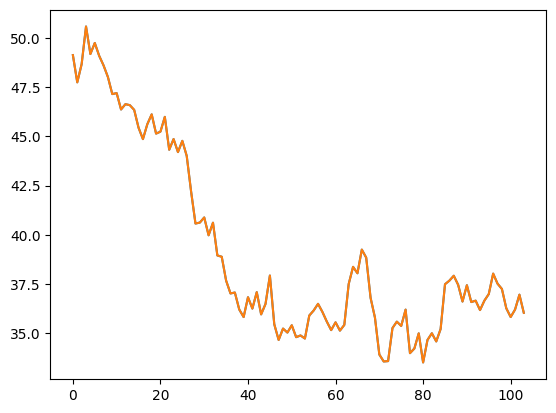

In [52]:
plt.plot(y_train)
plt.plot(y_train_pred)

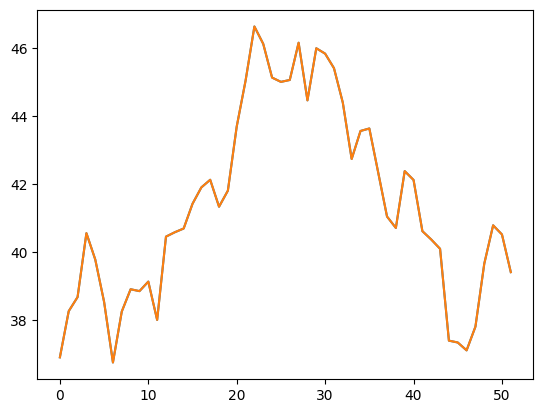

In [53]:
plt.plot(y_val)
plt.plot(y_val_pred)

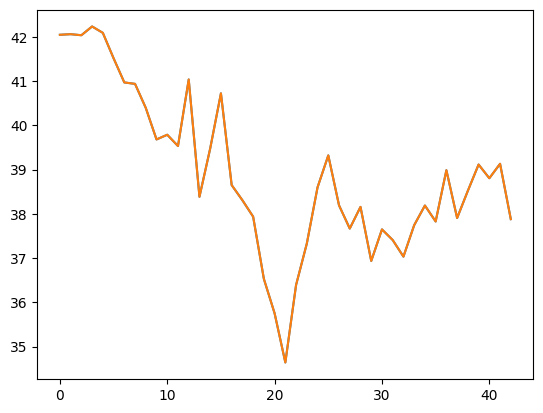

In [54]:
plt.plot(y_test)
plt.plot(y_test_pred)